# Intro to automatic differentiation (AD)
AD refers to a class of techniques that obtain derivatives from computer programs. These fall within three broad categories:

1. Forward AD, where the derivative of each operation is recorded together with the value as the program executes
2. Reverse AD, where the operations are recorded together with the value on a "tape", which is then traversed in reverse after the value has been computed to find the derivative
3. Source code or compiler-level AD that differentiates the source code or compiler intermediate representation to write a program that produces the derivatives

Optimal performance is usually a result of mix-and-matching these techniques.

## Creating a AD type
We define a subtype of the abstract `Number` type that holds a value and the partial derivative which can both be any kind of number that implements the concept of a dual (or tuple) number $\bar{v}$ that holds both the value $v$ of some expression and the partial derivative of that expression with respect to our independent variable $x$:
$$\bar{v} = \langle v, \frac{\partial v}{\partial x} \rangle$$

Julia has a fairly constrained type system when compared to e.g. C++. For example, Julia does not allow for concrete inheritance -- only inheritance from abstract types that cannot be instantiated and do not have any properties. In the constructor, we make the derivative optional and defaulted to the `zero` of the value type. This is important, as it will allow Julia to convert any number to the AD type with the reasonable default of zero derivative.

In [2]:
"Type that holds value and derivative"
struct AD <: Number
    v
    dv
    function AD(val::Number, der::Number = zero(val))
        return new(val, der)
    end
end
# AD with value 2.0 and derivative 1.0:
AD(2.0, 1.0)

AD(2.0, 1.0)

## Some utilities
If we want to work with derivatives, we should also define utilities for getting the value and derivative of numbers. We define also generic methods for the `Any` supertype, where the value is the entry itself and the derivative is zero. This means that we can write generic code without having to explicitly convert values to AD when needed. All Julia types are instances of `Any`. Julia will pick the most concrete function specialization: `AD<:Number` and `Number<:Any` means that `value(::AD)` will be called instead of `value(::Any)`. 

In [3]:
value(x) = x # Short-hand for value(x::Any) = x
value(x::AD) = x.v
derivative(x) = zero(x)
derivative(x::AD) = x.dv

derivative (generic function with 2 methods)

### Deconstruction of AD values
We can also define a convenience function that unpacks the value and derivative (can be used as two output arguments)

In [4]:
value_and_derivative(x) = (value(x), derivative(x))
v, v′ = value_and_derivative(AD(1.0, 5.0))
println("Value was $v, derivative $v′")

Value was 1.0, derivative 5.0


### Pretty printing by multiple dispatch
Customizing standard functionality for types in Julia is then done by creating specialized versons of the default functions (similar to operator overloading, but with multiple dispatch). We will modify the default `show` method used to print the type as an example. Let's make it closer to our notation:

In [5]:
import Base: show
show(io::IO, x::AD) = print(io, "⟨$(x.v), ∂/∂x=$(x.dv)⟩")
x = AD(2.0, 1.0)

⟨2.0, ∂/∂x=1.0⟩

We remark that this is a specialization for both the type of `show` stream (`::IO`) and the object to be shown (`::AD`). Other `show` methods that involve our `AD` type could behave differently, and we could further specialize on specific subtypes of `IO`, for example `Core.CoreSTDERR` to specialize for error messages.

## Adding things up
Next up, let us specialize another base function, the binary addition operator `+`:

In [6]:
import Base.+
function (+)(U::AD, V::AD)
    u, u′ = value_and_derivative(U) # u = value(U), u′ = derivative(U)
    v, v′ = value_and_derivative(V)
    return AD(u + v, u′ + v′)
end
x = AD(2.0, 1.0)
y = AD(10.0, 1.5)
x + y

⟨12.0, ∂/∂x=2.5⟩

## Picking a spot in the type hierarchy
Our `AD` type depends on the abstract `Number` type. For our `AD` type to be useful, we are going to need several binary operators of the form `a+b` and `a*b` to be compatible with `AD` together with other numbers like `Float32` or `Float64`. If we were to call our addition operator with `AD` and a regular number, we would get an error message saying that there is no function `+` for `AD` and `Float64`.

We want to avoid writing seperate functions for `AD * Float64` and `Float64 * AD` and so on: For type stability, we always want `AD` output when any of the inputs are `AD`. We can formalize this by implementing the `promote_rule` for our `AD` type.

In [7]:
import Base: promote_rule
promote_rule(::Type{T}, ::Type{<:Number}) where {T<:AD} = T
# Note difference in function name and calling order!
promote_type(Float64, AD) # or promote for type instances

AD

It is worth noting that this function is dispatching on the "type of type AD" `Type{<:AD}` and not the type `AD` itself. This is because the choice of what function to use happens on the compile level, which is also defined through Julia code. We are in fact performing some light meta-programming without any use of macros here.

Now, any call of the type `a*b` where `a` is `AD` and `b` is some other number will result in the function `a*convert(AD, b)` being called. `convert(AD, b)` will call our single input constructor, creating a AD object with zero derivative. Let us test it out:

In [8]:
AD(1.0, 1.0) + 3.0

⟨4.0, ∂/∂x=1.0⟩

## Multiplicative effects
Let us add multiplication as our next feature:
$$(uv)' = u'v + uv'$$

In [9]:
import Base.*
function (*)(U::AD, V::AD)
    u, u′ = value_and_derivative(U)
    v, v′ = value_and_derivative(V)
    return AD(u*v, u′*v + u*v′)
end


* (generic function with 365 methods)

In [10]:
x = AD(2.0, 1.0)
y = AD(10.0, 1.5)
x*y

⟨20.0, ∂/∂x=13.0⟩

In [11]:
2.0*AD(3.5, 1.0)

⟨7.0, ∂/∂x=2.0⟩

In [22]:
using Pkg; Pkg.add("Plots");

   Resolving package versions...
  No Changes to `D:\jobb\bitbucket\moyner.jl\Project.toml`
  No Changes to `D:\jobb\bitbucket\moyner.jl\Manifest.toml`


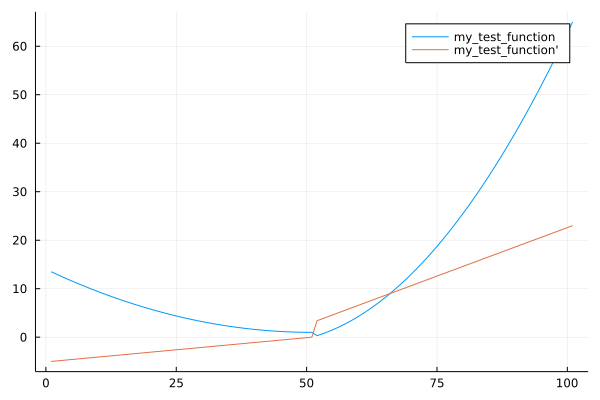

In [21]:
function my_test_function(X)
    if value(X) > 0
        Y = X*X*2.0 + 3.0*X
    else
        Y = 0.5*X*X + 1.0
    end
    return Y
end

X = [AD(x, 1.0) for x in -5.0:0.1:5.0]
Y = my_test_function.(X)
using Plots
plot(value.(Y), label = "my_test_function")
plot!(derivative.(Y), label = "my_test_function'")

## Numerous numbers
The `AD` type is generic for any kind of `Number`, so we can immediately try complex numbers:

In [14]:
AD(1.0 + 2im, 1.0) + AD(5.0 - 0.1im, 0.5im)

⟨6.0 + 1.9im, ∂/∂x=1.0 + 0.5im⟩

Our use of `promote_rule` now really pays off -- we can mix complex and real numbers with our AD type without issue, as the reals are first promoted to complex, and complex to dual!

In [15]:
AD(1.0 + 2im, 1.0) + AD(5.0, 1.0)

⟨6.0 + 2.0im, ∂/∂x=2.0⟩

## Numbers wrapping Numbers
We defined our AD class to work on `Number` instances for both value and derivative. Note that we did not specify that the value and derivative should be the same type of number. Maybe you also saw that our `AD` type itself is *also* a number? We have secretly been implementing derivatives of **any** order.

In [16]:
# X has value 1.5, X' = 1.0, X'' = 0.8
X = AD(1.5, AD(1.0, 0.8))
# Y has value 3, Y' = 0.5, Y'' = 0
Y = AD(3.0, 0.5)
F = X*Y + 0.2*Y

⟨5.1, ∂/∂x=⟨3.85, ∂/∂x=2.4000000000000004⟩⟩

In [17]:
value(F)

5.1

In [18]:
derivative(F)

⟨3.85, ∂/∂x=2.4000000000000004⟩

In [19]:
derivative(derivative(F))

2.4000000000000004

## A note on performance and concrete types
We have now seen that it is easy to implement `AD` with Julia (and many other languages). Our `AD` type is not as performant as it could be, however, as the type does not actually encode what kind of types the value and derivative are -- we just check in the constructor that they are numbers. For the compiler, this means that it is very hard to predict what methods to call for any given `AD` instance. Performance can be significantly increased if we make the type *parametric* on the type of the value and derivative so that a unique type is defined for each type of variable derivative type pair.

The nice thing about Julia is that it is easy enough to skip type details when you are writing code, and then optimize once the structure is settled. Here is a quick draft of how an optimized type might look like:
```julia
struct AD{V, D} <: Number
    v::V
    dv::D
end
# Constructor without derivative (for e.g. Float64 -> AD)
AD{T, V}(v) where {T, V} = AD(convert(T, v), zero(V))

# Constructor with derivative
AD(v::T, ∂::D) where {T,D} = AD{T, D}(v, ∂)
AD(v::T) where T = AD(v, zero(T))
```

## Try it yourself
1. Implement a few more operators like `Base.sin`, `Base.exp` from [the standard library](https://docs.julialang.org/en/v1/manual/mathematical-operations/) and create a more interesting version of `my_test_function` of your own devising.
2. We defined scalar `AD` with repect to a single variable. How can this type be used to obtain gradients?
3. Our type is essentially a simplified version of the [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) dual number type implemented [here](https://github.com/JuliaDiff/ForwardDiff.jl/blob/master/src/dual.jl). Take a look at the source code for a performance-critical Julia type - how different is it from our simple "MATLAB/Python-like code"?

10 minutes, then we discuss these points together.

In [20]:
import Base: sin
function sin(x::AD)
    error("This is where you come in...")
end

sin(AD(2π))

LoadError: This is where you come in...

## Conclusion
We have seen how it is easy to implement forward-mode AD. This is not the end of the story, however, as there are many topics we have not discussed:

- We only worked with scalar AD, but for functions with multiple inputs it is important to support Jacobians and Hessians.
- Non-scalar AD means matrix formats, implicit definitions of `J*v` products, memory allocation ...
- Sparsity becomes a big issue for many applications, including PDEs - not all derivatives should be computed.
- Custom numerical types relies on the code being flexible with respect to input types - using `Number` instead or `AbstractFloat` instead of `Float64` in their declarations.

The [JuliaDiff](https://juliadiff.org/) organization contains links to many packages that can be tested. Some are experiments and others are very high quality and have been around for a long while:
- [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) is a highly efficient forward-mode implementation.
- [ReverseDiff.jl](https://github.com/JuliaDiff/ReverseDiff.jl) is an implementation of reverse-mode AD.
- [Zygyote.jl](https://github.com/FluxML/Zygote.jl) is reverse mode source transformation implementation that is applied to the Julia IR.